In [5]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

##Upload Data and unzip them

In [ ]:
# Un-comment this section if need to remove any folder/directory
# !rm -rf /content/data

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data/

In [ ]:
###Unzip DATA###

#Before run the code section, manually upload data to the file space / work space
# !unzip /content/original_img.zip -d /content/data/
# !unzip /content/masked_img.zip -d /content/data/
# os.rename('/content/data/Images','/content/data/original_img')

# 7min16sec to unzip
! unzip /content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/archive.zip -d /content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/

In [ ]:
###Functions for Pre-Process DATA###
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img


# ress1=Image.open('/content/data/original_img/1.png') #'/content/d/masked_img/1.png'
# ress2=Image.open('/content/data/masked_img/1.png')
# img1=ress1.resize((1540,640), Image.ANTIALIAS)
# img2=ress2.resize((1540,640), Image.ANTIALIAS)

# fig = plt.figure(figsize = (32,32))
# ax = fig.add_subplot(2, 2, 1) 
# plt.imshow(img1)
# ax = fig.add_subplot(2, 2, 2) 
# plt.imshow(img2)
# plt.show()

In [ ]:
###display some processed result to double check
fig = plt.figure(figsize = (30,7))
# for index in range(7):
#   file_path1 = os.path.join('/content/data/original_img', str(index+1)+'.png')
#   file_path2 = os.path.join('/content/data/masked_img', str(index+1)+'.png')
#   # print(file_path2)
#   ax = fig.add_subplot(2, 7, index+1) 
#   plt.imshow(pre_images((1540,640),file_path1))  #show result of converting every img to one color channel
#   # plt.imshow(cv2.imread(file_path1))
    
#   ax = fig.add_subplot(2, 7, index+8)
#   plt.imshow(resize((1540,640),file_path2))
#   # plt.imshow(cv2.imread(file_path2))
plt.show()
#notice that some images has no teeth, this will make training harder

<Figure size 2160x504 with 0 Axes>

#Loader

In [ ]:
def pad_img(path):
  # read image
  img = Image.open(path)
  img = np.array(img)
  old_image_height, old_image_width, channels = img.shape

  #rows_to_add = 16 - (old_image_width % 16)
  #cols_to_add = 16 - (old_image_height % 16)

  # create new image of desired size and color (blue) for padding
  new_image_width = 1536
  new_image_height = 1536
  #new_image_width = old_image_width + rows_to_add
  #new_image_height = old_image_height + cols_to_add

  color = (0,0,0)
  result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

  # compute center offset
  #x_center = (new_image_width - old_image_width) // 2
  #y_center = (new_image_height - old_image_height) // 2

  # copy img image into center of result image
  #result[y_center:y_center+old_image_height, x_center:x_center+old_image_width] = img

  # copy img image into upper left corner of result image
  result[0:old_image_height, 0:old_image_width] = img

  return result

In [ ]:
# Text OCR Dataloader 
rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
  def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        #self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test

        # Only useful columns are: id, width, height
        self.images_df = pd.read_csv(f'{self.root_dir}img.csv')
        # Only Useful colums are: id, image_id, bbox, utf8_string
        annotations_df = pd.read_csv(f'{self.root_dir}annot.csv')

        # process rows with puctuaitons in text
        # TODO
        
        # if data in df have same image_id, group them together
        annotations_df_grouped = annotations_df.groupby('image_id').agg(lambda x: list(x))
        
        # 70% tain, 15% valid, 15% test
        self.train_data, self.rest_data = train_test_split(annotations_df_grouped, test_size = rest_set_size, random_state = 5)
        self.validation_data, self.test_data = train_test_split(annotations_df_grouped, test_size = test_set_size, random_state = 5)

    

  # TODO: implement train, val, and test set length
  def __len__(self):
    if self.train:
      length = len(self.train_data)
    elif self.test:
      length = len(self.test_data)
    else:
      length = len(self.validation_data)
    return length
  

  # for now, this will return:
  # X: the image (padded)
  # Y: the list of bounding boxes
  def __getitem__(self, index):
    # here is how to retrieve row "names" : self.train_data.index.values[index]
    filename = ""
    if self.train:
      filename = self.train_data.index.values[index]
    elif self.test:
      filename = self.test_data.index.values[index]
    else:
      filename = self.validation_data.index.values[index]
    
    #print(f'{self.root_dir}train_val_images/train_images/{filename}.jpg')
    '''
    imx = Image.open(f'{self.root_dir}train_val_images/train_images/{filename}.jpg')
    imx = np.asarray(imx)
    # padding
    shape = imx.shape
    rows = shape[0]
    cols = shape[1]
    rows_to_add = 16 - (rows % 16)
    cols_to_add = 16 - (cols % 16)
    imx = np.pad(imx, ((0, rows_to_add), (0, cols_to_add)), 'constant')
    '''
    imx = pad_img(f'{self.root_dir}train_val_images/train_images/{filename}.jpg')
    #print(imx.shape)


    if self.train:
      annot = self.train_data.loc[filename, 'bbox']
      text = self.train_data.loc[filename, 'utf8_string']
    elif self.test:
      annot = self.test_data.loc[filename, 'bbox']
      text = self.test_data.loc[filename, 'utf8_string']
    else:
      annot = self.validation_data.loc[filename, 'bbox']
      text = self.validation_data.loc[filename, 'utf8_string']
      

    sample = {'image': imx, 'annotation': annot, 'text': text}
    return sample

#path = '/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/train_val_images/train_images/00c359f294f7dcd9.jpg'
#img = pad_img(path)

'''
print(img.shape)
img_orig=cv2.imread(path)
plt.imshow(img)
plt.figure()
plt.imshow(img_orig)
plt.show()
'''


'\nprint(img.shape)\nimg_orig=cv2.imread(path)\nplt.imshow(img)\nplt.figure()\nplt.imshow(img_orig)\nplt.show()\n'

In [ ]:
#test
OCRdata.train_data.index.values[0]



'2e3c03ba7450e47b'

['[300.75, 28.83, 47.1, 23.79]', '[442.64, 76.87, 26.3, 14.8]', '[437.59, 145.79, 18.7, 14.9]', '[166.4, 242.95, 40.8, 14.2]', '[305.5, 238.95, 69.9, 17.3]', '[342.93, 182.07, 26.19, 26.88]', '[168.65, 278.57, 59.6, 22.3]', '[184.35, 292.87, 55.9, 18.0]', '[219.42, 447.0, 26.3, 28.6]', '[319.99, 485.85, 77.2, 23.5]', '[187.37, 502.3, 57.3, 21.9]', '[282.53, 615.98, 115.96, 39.17]', '[223.14, 667.11, 33.42, 29.87]', '[250.59, 452.32, 10.92, 10.49]']
['at&t', '3:50', '→', 'AT&T', 'Messaging', ':-)', 'project', 'detroit', 'O', 'Marketplace', 'Outlook', 'SAMSUNG', '←', '.']


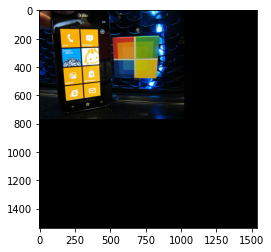

In [ ]:
OCRdata = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=True,test=False,)
# data = OCRdata.__getitem__(0)
# get data, if path does not exist, then pass

plt.imshow(data['image'])
print(data['annotation'])
print(data['text'])

In [ ]:
###Load DATA
rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
    def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test
        
        # split the dataset to train and rest
        # split the rest to validation and test
        self.train_data, self.rest_data = train_test_split(self.pixel_file, test_size = rest_set_size, random_state = 5)
        self.validation_data, self.test_data = train_test_split(self.rest_data, test_size = test_set_size, random_state = 5)

    def __len__(self):
        if self.train:
          length = len(self.train_data)
        elif self.test:
          length = len(self.test_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
        if self.train:
          imx_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0].replace('.png','_m.png'))
        elif self.test:
          imx_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0].replace('.png','_m.png'))
        else:
          imx_name = os.path.join(self.root_dir, 'original_img', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.validation_data.iloc[index, 0].replace('.png','_m.png'))
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        ##data augmentation
        if self.train:
          #Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # #Random vertical flipping
          # if random.random() > 0.5:
          #     imx = TF.vflip(imx)
          #     imy = TF.vflip(imy)

          # #Random rotation
          # if random.random() > 0.8:
          #   angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          #   imx = TF.rotate(imx, angle)
          #   imy = TF.rotate(imy, angle)

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)
      
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
###initialize data_loaders
tx_X = transforms.Compose([transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))])
tx_Y = transforms.Compose([transforms.ToTensor()
                        ])

train_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=True, test=False, transformX = tx_X, transformY = tx_Y)
validation_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=False, test=True,transformX = tx_X, transformY = tx_Y)



train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

In [ ]:
epoches=100
for i in range(epoches):
  for j, item in enumerate(train_loader):
  

In [ ]:
print('length')
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

length
7622
5445
5445


#Model

In [ ]:
import torch.nn as nn


class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [ ]:
model = CRNN(1152, 3, 37, 256)
if torch.cuda.is_available():
    model = model.to('cuda')

In [ ]:
model.modules

<bound method Module.modules of CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNo

#Loss and Optimizer

In [ ]:
# Using Adam as our optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # weight_decay=

In [ ]:
# Using Loss()
criterion = nn.CTCLoss()

#Train and Validation (TO DO)

In [ ]:
# training the model
# https://github.com/meijieru/crnn.pytorch/blob/master/train.py
def train(model, train_loader, validation_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, item, in enumerate(train_loader):
            if torch.cuda.is_available():
                item['image'] = item['image'].to('cuda')
                item['text'] = item['text'].to('cuda')
            # convert text to int, image to float tensor
            item['image'] = item['image'].type(torch.FloatTensor)
            item['text'] = item['text'].type(torch.LongTensor)
            
            # forward pass
            output = model(item['image'])
            output = output.permute(1, 0, 2)
            output = output.log_softmax(2)
            output = output.permute(1, 0, 2)
            # calculate loss
            loss = criterion(output, item['text'], torch.IntTensor([output.size(0)] * item['image'].size(0)), torch.IntTensor([item['text'].size(0)] * item['image'].size(0)))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if i % 100 == 0:
                print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, i, loss.item()))
        print('Epoch: {}, Train Loss: {}'.format(epoch, train_loss / len(train_loader)))

model = train(model, train_loader, validation_loader, optimizer, criterion, 10)

In [ ]:
# validation
def validation(model, validation_loader, criterion):
    model.eval()
    validation_loss = 0
    for i, item, in enumerate(validation_loader):
        if torch.cuda.is_available():
            item['image'] = item['image'].to('cuda')
            item['text'] = item['text'].to('cuda')
        # convert text to int, image to float tensor
        item['image'] = item['image'].type(torch.FloatTensor)
        item['text'] = item['text'].type(torch.LongTensor)
        # forward pass
        output = model(item['image'])
        output = output.permute(1, 0, 2)
        output = output.log_softmax(2)
        output = output.permute(1, 0, 2)
        # calculate loss
        loss = criterion(output, item['text'], torch.IntTensor([output.size(0)] * item['image'].size(0)), torch.IntTensor([item['text'].size(0)] * item['image'].size(0)))
        validation_loss += loss.item()
    print('Validation Loss: {}'.format(validation_loss / len(validation_loader)))

In [ ]:
# testing
def test(model, test_loader):
    model.eval()
    for i, item, in enumerate(test_loader):
        if torch.cuda.is_available():
            item['image'] = item['image'].to('cuda')
            item['text'] = item['text'].to('cuda')
        # convert text to int, image to float tensor
        item['image'] = item['image'].type(torch.FloatTensor)
        item['text'] = item['text'].type(torch.LongTensor)
        # forward pass
        output = model(item['image'])
        output = output.permute(1, 0, 2)
        output = output.log_softmax(2)
        output = output.permute(1, 0, 2)
        # calculate loss
        loss = criterion(output, item['text'], torch.IntTensor([output.size(0)] * item['image'].size(0)), torch.IntTensor([item['text'].size(0)] * item['image'].size(0)))
        print('Test Loss: {}'.format(loss.item()))

In [ ]:
# Old
from tqdm.notebook import tqdm
def train(model, criterion, epochs = 5, verbose=False):
  if not train_hist:
    train_hist = []
  if not val_hist:
    val_hist = []
    
  torch.cuda.empty_cache()
    
  tqdm.write("====== Training Started ======")
  epochs_completed = 0
  for e in tqdm(range(epochs), position=0, desc="Epochs", leave=False, colour='green'):
    train_running_loss = 0.0
    validation_running_loss = 0.0
    ct = 0.0
    
    model.train()
    
    # print("Losses are reset to:", train_running_loss, validation_running_loss, ct)
    for ith_batch, sample in tqdm(enumerate(train_loader), position=1, desc="Batches", leave=False, total=len(train_loader), colour='blue'):
      X, Y = sample['image'], sample['annotation']

      if torch.cuda.is_available():
        X = X.to('cuda')
        Y = Y.to('cuda')

      y_pred = model(X)
    # out = (y_pred + 0.5).int().float()
      
      # loss = criterion(y_pred, Y) #* 0.70 + 0.30 * dice_loss(y_pred, y_train)
      loss=0.3*dice_loss(y_pred, Y)+0.7*criterion(y_pred, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if verbose and ith_batch % 10 == 0 and ith_batch != 0:
        # print("This item's loss:", f'{loss.item()}')
        # print("This pred started with", y_pred[0][0][0][0:10])
        tqdm.write('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Curr Epoch Loss: ', f'{train_running_loss / ct:0.3f}')
        
      train_running_loss += loss.item()
      train_hist.append(loss.item())
      ct += 1.0

In [ ]:
total_epochs=0

In [ ]:
num_epochs = 100
# and visualize the full training graph
completed_epochs = train(model, criterion, epochs=num_epochs, verbose=False)
total_epochs+=completed_epochs

In [ ]:
torch.save(model.state_dict(),'/content/best_unet_051722_v1.pth')

# Test

Once the training is completed, we just need to upload the model and run from here.

In [ ]:
# Load saved model
model = Class()
model.load_state_dict(torch.load('/content/best_unet_051722_v1.pth'))

In [ ]:
###Load DATA

test_set_size = 0.5
class dset(Dataset):
    def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test
        
        # split the dataset to train and rest
        # split the rest to validation and test
        self.train_data, self.test_data = train_test_split(self.pixel_file, test_size = test_set_size, random_state = 5)
        # self.validation_data, self.test_data = train_test_split(self.rest_data, test_size = test_set_size, random_state = 5)

    def __len__(self):
        if self.train:
          length = len(self.train_data)
        elif self.test:
          length = len(self.test_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
        if self.train:
          imx_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0].replace('.png','_m.png'))
        elif self.test:
          imx_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0].replace('.png','_m.png'))
        else:
          imx_name = os.path.join(self.root_dir, 'original_img', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.validation_data.iloc[index, 0].replace('.png','_m.png'))
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)
      
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
tx_X = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor()
                              ])
train_data = dset('/content/data', train=True, test=False, transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/data', train=False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

In [ ]:
#test
def avg_dice_index(dataloader): 
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
    print(len(dataloader))
    avg_dice = dice / len(dataloader)
    
    return avg_dice.item()

In [ ]:
test_score=avg_dice_index(test_loader)

29


In [ ]:
print('Avergae Dice Score is:',test_score)
print('Avergae Dice Loss is:',1-test_score)

Avergae Dice Score is: 0.9117302298545837
Avergae Dice Loss is: 0.08826977014541626


#Post-Process